## Depth Book

In [1]:
import os
import secrets
from PIL import Image
import numpy as np
import pickle

In [2]:
import shutil


#### Sort Data:

In [3]:
# This function is used to gather the data from the folders that the GUI places them in,
# split them into training sets and validation sets by name and save the names into dictionaries.

def julias_knife(file_path = "Apocrypha V1 Elana/Cam Data Folders", valid = 0.3):
    
    # Must seperate file names into 
    
    entries = os.listdir(file_path)
    training_dict = {}
    valid_dict = {}
    
    for entry in entries:
        bottle = os.listdir(file_path + "/" + entry)
        for cam_type in bottle:
            sample_list = os.listdir(file_path + "/" + entry + "/" + cam_type)
            spin_number = int(round(len(sample_list)*(1-valid)))
            for i in range(spin_number):
                selected = secrets.choice(sample_list)
                try:
                    training_dict[entry + " " + cam_type].append(selected)
                except:
                     training_dict[entry + " " + cam_type] = [selected]
                
                index = sample_list.index(selected)    
                del sample_list[index]
            valid_dict[entry + " " + cam_type] = sample_list
        
    return training_dict, valid_dict



In [4]:
# This function is used to convert images saved as Numpy arrays to .jpg file and save them.
def julias_saving_engine(some_kind_of_dictionary, train_valid_type = "test", source = "Apocrypha V1 Elana/Cam Data Folders"):
    for key in some_kind_of_dictionary.keys():
        cutter = key.split(" ")
        cam_type = cutter[-1]
        hand_type = cutter[0]
        i = 1
        while i < (len(cutter) - 1):
            hand_type = hand_type + " " + cutter[i]
            i += 1
        destination_folder = "Data Converted to JPG" + "/" + cutter[-1] + "/" + train_valid_type + "/"+ hand_type
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)
        for entry in some_kind_of_dictionary[key]:
            #print(entry)
            source_path = source + "/" + hand_type + "/" + cam_type + "/" + entry
            destination_path = destination_folder + "/" + entry.split(".")[0] + ".jpg"

            
            with open(source_path, 'rb') as file:
                image_array = pickle.load(file) 
                
            # Convert the NumPy array to an image
            image = Image.fromarray(np.uint8(image_array))  # Ensure the array is of type uint8

        
            image.save(destination_path)


In [5]:
# Here we use them.

# We set this with a switch so that we won't run it by accident when we do not want to.
if False:
    train_valid_list_dicts = julias_knife(valid = 0.2)
    train_valid_names_list = ["train", "valid"]
    for i in range(len(train_valid_names_list)):
        julias_saving_engine(train_valid_list_dicts[i],train_valid_type = train_valid_names_list[i])

#### Prepare and Train Model:

In [6]:
import fastbook
fastbook.setup_book()
from fastai.vision.all import *

In [7]:
# Set data location.
export_path = Path('Data Converted to JPG');
export_path.ls();

In [8]:
# Prepare the data using fastai DataBlock and dataloaders.

set_seed(44, reproducible=True)
fingers = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(640),
    batch_tfms=aug_transforms(size=420));
dls = fingers.dataloaders(export_path, bs = 32);

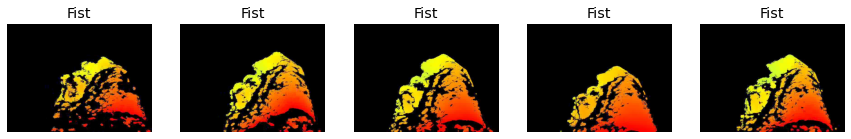

In [12]:
these_here_fingers = fingers.new(batch_tfms=aug_transforms(mult=3, max_rotate = 0, max_lighting = 0.1, max_warp = 0))
that_other_dls = these_here_fingers.dataloaders(export_path, bs = 32)
that_other_dls.valid.show_batch(max_n=5,nrows=1)

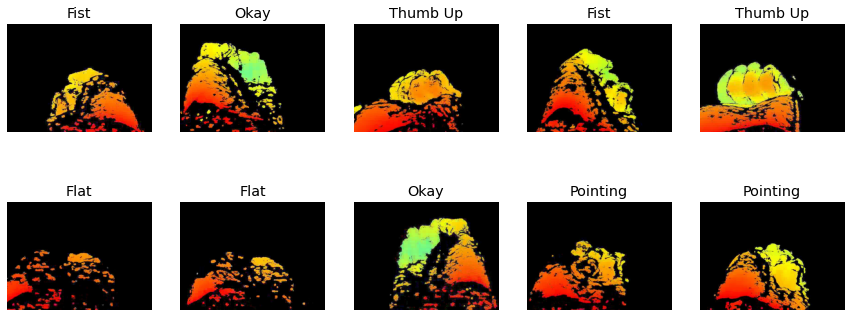

In [13]:
that_other_dls.train.show_batch(max_n=10,nrows=2)

In [14]:
from joblib import dump, load

In [15]:
import joblib

In [16]:
# Set up our RezNet neural net. Use 18 layers.

set_seed(44, reproducible=True)
machine = vision_learner(that_other_dls,resnet18,metrics=accuracy)

SuggestedLRs(valley=0.001737800776027143)

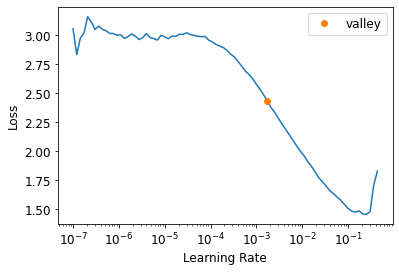

In [17]:
machine.lr_find()

In [135]:
# Pickle the model so we we don't need to repeat the steps above if something goes wrong.

machine.export('machine_pretrainin.pkl');

In [18]:
machine2 = machine

In [139]:
from fastai.learner import load_learner

# Load the entire learner
machine2 = load_learner('machine_pretrainin.pkl')

In [19]:
# Train for three cycles before unfreezing model.

set_seed(44, reproducible=True)
machine2.fit_one_cycle(3, 6e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.344769,4.410728,0.238095,02:00
1,0.716987,0.839311,0.704762,02:04
2,0.492942,0.108582,0.942857,02:08


SuggestedLRs(valley=0.00013182566908653826)

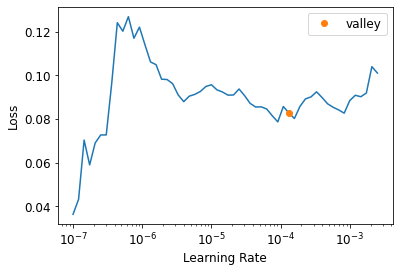

In [20]:
# Unfreeze model and find a learning rate for further training.

machine2.unfreeze()
set_seed(44, reproducible=True)
machine2.lr_find()

In [21]:
# 7e-5 to 2e-4 looks good judging by graph.
# Train for 7 epochs, as when we tried training longer it did not help.
set_seed(44, reproducible=True)
machine2.fit_one_cycle(7, lr_max=slice(7e-5,2e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.093166,0.120949,0.971429,03:06
1,0.087692,0.217363,0.895238,03:03
2,0.077354,0.177096,0.923810,03:03
3,0.054829,0.028969,0.980952,03:04
4,0.040794,0.035768,0.980952,03:04
5,0.034620,0.015435,0.990476,03:06
6,0.030653,0.010152,0.990476,03:01


#### Save Model:

In [22]:
# Save resulting neural net.
machine2.export('clever_shae.pkl')

In [155]:
# Try doing a test prediction.

from fastai.vision.core import PILImage

# Load the image
img_path = 'Test Data/Depth/valid/Flat/sample58.jpg'
img = PILImage.create(img_path)

# Make a prediction
pred_class, pred_idx, outputs = machine2.predict(img)

print(f"Predicted class: {pred_class}, Predicted index: {pred_idx}, Outputs: {outputs}")

Predicted class: Flat, Predicted index: 1, Outputs: tensor([6.1406e-06, 9.9999e-01, 1.1535e-10, 1.1788e-06, 1.0412e-06])


In [156]:
from fastai.learner import load_learner
from fastai.vision.core import PILImage

# Load the exported learner
path_to_exported_file = 'clever_shae.pkl'  # Adjust the path if necessary
machine3 = load_learner(path_to_exported_file)



# Make a prediction
pred_class, pred_idx, outputs = machine3.predict(img)
print(f"Predicted class: {pred_class}")

Predicted class: Flat
